**Author:** Joaquín Torres Bravo  
**Date:** June 2024  
**Institution:** Universidad Carlos III de Madrid  
**Bachelor Thesis**

---

### Code Adaptations

Portions of this code are adapted from the work by Ben Moseley, originally published in 2022. The original source, which is licensed under the MIT License, can be accessed through the following link:  
[Ben Moseley's Harmonic Oscillator PINN Workshop](https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb)

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm as tqdm
from scipy.integrate import odeint

Solving SIR Model Numerically

In [2]:
def SIR(x, t, N, beta, gamma):
    S, I, R = x
    xdot = [
        -(beta*S*I)/N,
        (beta*S*I)/N - gamma*I,
        gamma*I
    ]
    return xdot

In [3]:
# Total population, N.
N = 100
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial state of the system
X0 = [S0, I0, R0]

# Parameters
beta, gamma = 1.5, 0.5

# A grid of time points (in days)
finalT = 17.0
t  = np.linspace(0, finalT, 100)

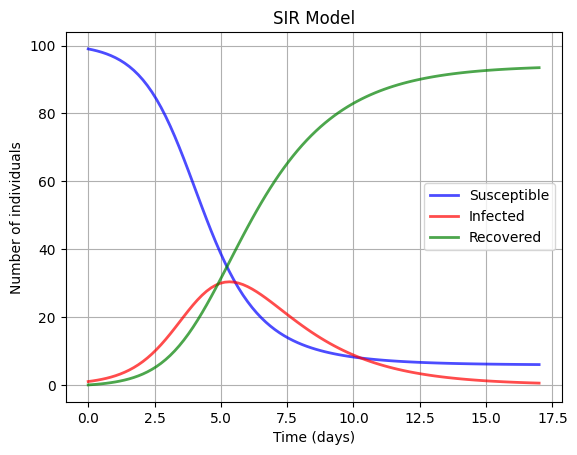

In [4]:
# Integrate the SIR equations over the time grid, t.
result = odeint(SIR, X0, t, args=(N, beta, gamma))
S, I, R = result.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
plt.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()

Generating Observational Data

In [12]:
# Generate 10 equispaced time locations in the domain for fair comparison with ABC-SMC
obs_ind = np.linspace(0, len(t) - 1, 10, dtype=int)

S_obs = [S[ind] for ind in obs_ind]
I_obs = [I[ind] for ind in obs_ind]
R_obs = [R[ind] for ind in obs_ind]

# Generate Gaussian noise for S_obs, I_obs, and R_obs
noise_S = 0.5 * np.random.randn(len(S_obs))
noise_I = 0.5 * np.random.randn(len(I_obs))
noise_R = 0.5 * np.random.randn(len(R_obs))

# Add the noise to the observed values
S_obs_noise = [S_obs[ind] + noise_S[ind] for ind in range(len(S_obs))]
I_obs_noise = [I_obs[ind] + noise_I[ind] for ind in range(len(I_obs))]
R_obs_noise = [R_obs[ind] + noise_R[ind] for ind in range(len(R_obs))]

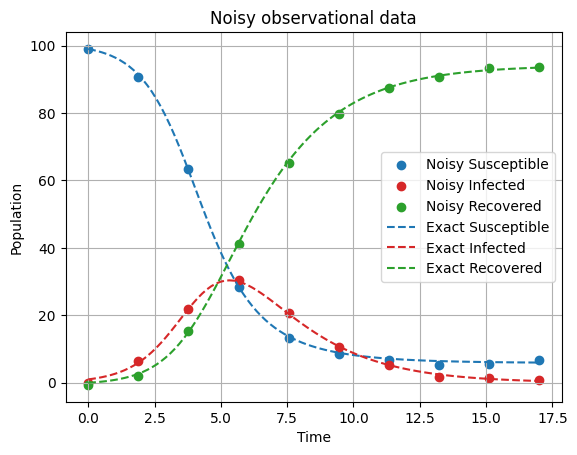

In [13]:
plt.figure()
plt.title("Noisy observational data")
plt.scatter([t[ind] for ind in obs_ind], S_obs_noise, label='Noisy Susceptible', color="tab:blue")
plt.scatter([t[ind] for ind in obs_ind], I_obs_noise, label='Noisy Infected', color="tab:red")
plt.scatter([t[ind] for ind in obs_ind], R_obs_noise, label='Noisy Recovered', color="tab:green")
plt.plot(t, S, label='Exact Susceptible', color="tab:blue", linestyle='--')
plt.plot(t, I, label='Exact Infected', color="tab:red", linestyle='--')
plt.plot(t, R, label='Exact Recovered', color="tab:green", linestyle='--')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


Tensors

In [14]:
# Tensor containing time locations for observations
t_obs = torch.tensor([t[ind] for ind in obs_ind], dtype=torch.float32).view(-1,1)
# Tensor with noisy observations for S
u_obs_S = torch.tensor(S_obs_noise,  dtype=torch.float32).view(-1,1)
# Tensor with noisy observations for I
u_obs_I = torch.tensor(I_obs_noise,  dtype=torch.float32).view(-1,1)
# Tensor with noisy observations for R
u_obs_R = torch.tensor(R_obs_noise,  dtype=torch.float32).view(-1,1)
# Tensor of times to train PINN through physics loss
t_physics = torch.linspace(0, finalT, 500).view(-1, 1).requires_grad_(True)
# Tensor of times to check progress of PINN when training
t_test = torch.linspace(0, finalT, 300).view(-1, 1).requires_grad_(True)

Defining the Network

In [15]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce_S = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.fce_I = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.fce_R = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        S_output = self.fce_S(x)
        I_output = self.fce_I(x)
        R_output = self.fce_R(x)
        return S_output, I_output, R_output

Training

  0%|          | 0/20000 [00:00<?, ?it/s]

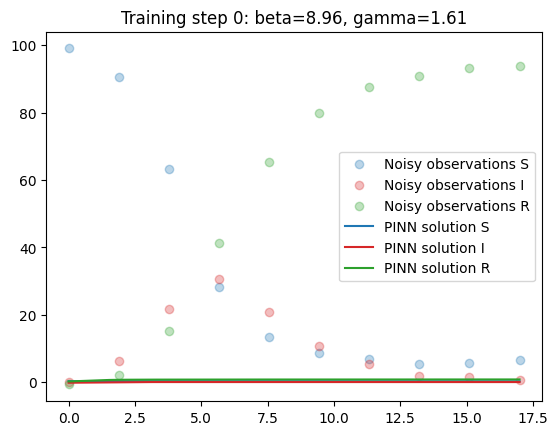

 20%|█▉        | 3996/20000 [00:38<02:10, 122.97it/s]

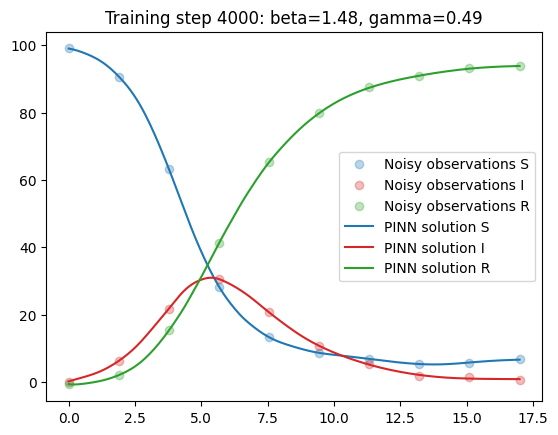

 40%|███▉      | 7999/20000 [01:15<01:53, 105.52it/s]

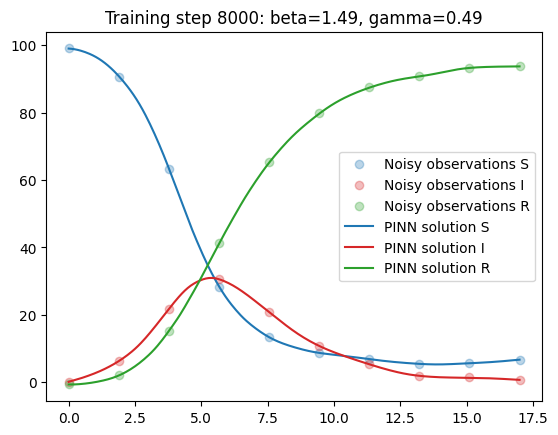

 60%|█████▉    | 11996/20000 [01:50<01:08, 117.32it/s]

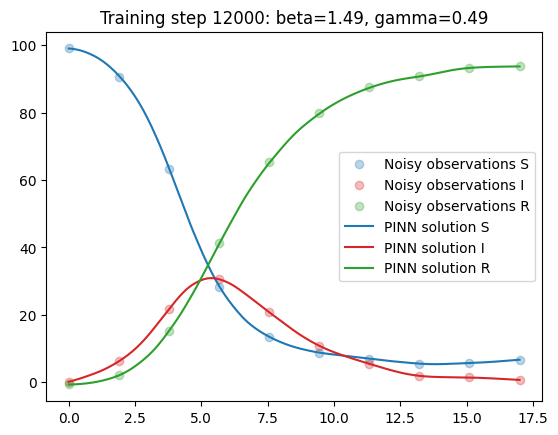

 80%|████████  | 16000/20000 [02:33<00:32, 122.58it/s]

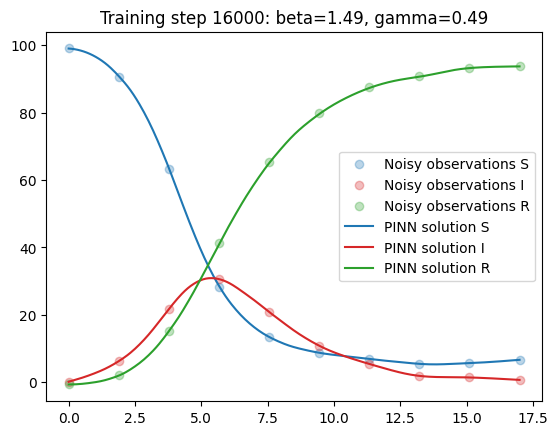

100%|██████████| 20000/20000 [03:09<00:00, 105.33it/s]


In [19]:
pinn = FCN(1,1,32,3)

# Initialize lists to store loss values
physics_loss_values = []
data_loss_values = []
total_loss_values = []

# LEARNABLE PARAMS
beta = torch.nn.Parameter(torch.empty(1).uniform_(0, 10), requires_grad=True)
betas = []
gamma = torch.nn.Parameter(torch.empty(1).uniform_(0, 10), requires_grad=True)
gammas = []

optimiser = torch.optim.Adam(list(pinn.parameters())+[beta,gamma],lr=1e-2)

n_its = 20000

for i in tqdm.tqdm(range(n_its)):
    optimiser.zero_grad()

    # Hyperparameter
    lambda1 = 10

    # -----------------------
    #       PHYSICS LOSS
    # -----------------------
    uS, uI, uR = pinn(t_physics)

    # Compute the derivatives with respect to time
    duSdt = torch.autograd.grad(uS, t_physics, torch.ones_like(uS), create_graph=True)[0]
    duIdt = torch.autograd.grad(uI, t_physics, torch.ones_like(uI), create_graph=True)[0]
    duRdt = torch.autograd.grad(uR, t_physics, torch.ones_like(uR), create_graph=True)[0]

    # Compute the physics loss for SIR equations
    phy_loss_S = torch.mean((duSdt + (beta * uS * uI) / N) ** 2)
    phy_loss_I = torch.mean((duIdt - (beta * uS * uI) / N + gamma * uI) ** 2)
    phy_loss_R = torch.mean((duRdt - gamma * uI) ** 2)

    total_physics_loss = phy_loss_S + phy_loss_I + phy_loss_R

    # -----------------------
    #       DATA LOSS
    # -----------------------
    # Compute the PINN output
    uS, uI, uR = pinn(t_obs)
    data_loss_S = torch.mean((uS - u_obs_S)**2)
    data_loss_I = torch.mean((uI - u_obs_I)**2)
    data_loss_R = torch.mean((uR - u_obs_R)**2)

    total_data_loss = data_loss_S + data_loss_I + data_loss_R

    # Backpropagate joint loss, take optimiser step
    loss = total_physics_loss + lambda1*total_data_loss
    loss.backward()
    optimiser.step()

    # Append loss values to lists
    physics_loss_values.append(total_physics_loss.item())
    data_loss_values.append(total_data_loss.item())
    total_loss_values.append(loss.item())

    # Keep track of parameter values
    betas.append(beta.item())
    gammas.append(gamma.item())

    # plot the result as training progresses
    if i % 4000 == 0: 
        uS, uI, uR = pinn(t_test)
        with torch.no_grad():
            plt.scatter(t_obs, u_obs_S, label="Noisy observations S", alpha=0.3, color="tab:blue")
            plt.scatter(t_obs, u_obs_I, label="Noisy observations I", alpha=0.3, color="tab:red")
            plt.scatter(t_obs, u_obs_R, label="Noisy observations R", alpha=0.3, color="tab:green")
            plt.plot(t_test, uS, label="PINN solution S", color="tab:blue")
            plt.plot(t_test, uI, label="PINN solution I", color="tab:red")  
            plt.plot(t_test, uR, label="PINN solution R", color="tab:green")  
            plt.title(f"Training step {i}: beta={beta.item():.2f}, gamma={gamma.item():.2f}")
            plt.legend()
            plt.show()


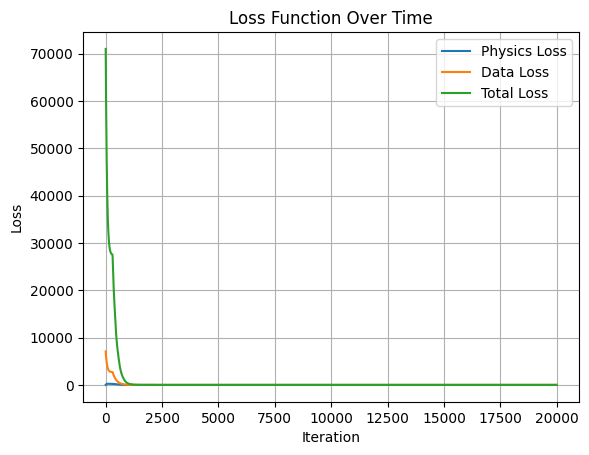

In [20]:
# Plot loss values over time
# plt.figure(figsize=(10, 5))
plt.plot(range(n_its), physics_loss_values, label='Physics Loss')
plt.plot(range(n_its), data_loss_values, label='Data Loss')
plt.plot(range(n_its), total_loss_values, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Function Over Time')
plt.legend()
plt.grid(True)
plt.show()

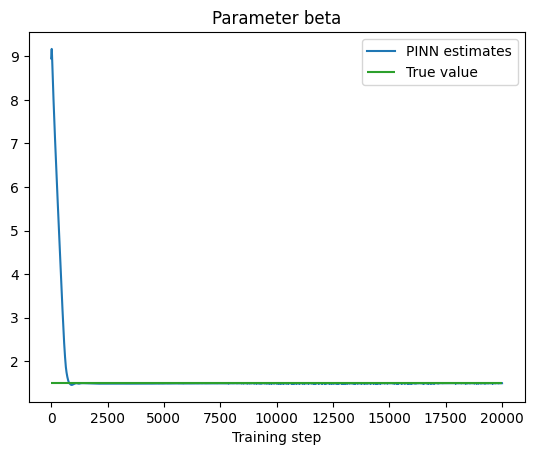

In [21]:
plt.figure()
plt.title("Parameter beta")
plt.plot(betas, label="PINN estimates")
plt.hlines(1.5, 0, len(betas), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

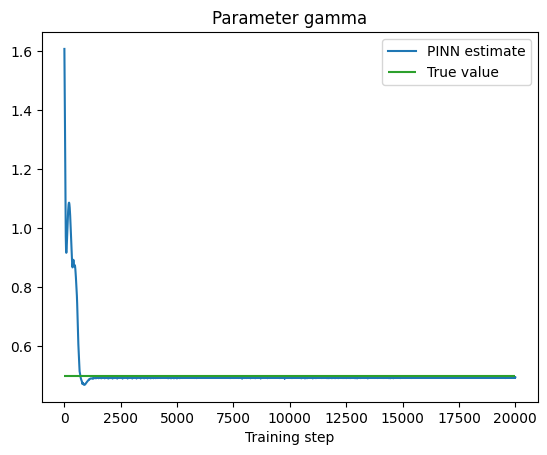

In [22]:
plt.figure()
plt.title("Parameter gamma")
plt.plot(gammas, label="PINN estimate")
plt.hlines(0.5, 0, len(gammas), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [23]:
print(beta, gamma)

Parameter containing:
tensor([1.4924], requires_grad=True) Parameter containing:
tensor([0.4940], requires_grad=True)
